In [1]:
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from PCAalg import *
import time

In [2]:
def generate_data(n_l, d, L, shared_d=5, latent_d=10, seed=42):
    np.random.seed(0)

    shared_W = np.random.randn(d, shared_d) * 1
   
    # Generate source-specific transformations (for last 5 latent dimensions)
    source_W = [0. + np.random.randn(d, latent_d - shared_d) * 0.25 for _ in range(L)]

    # Combine to create full transformation matrices for each source
    W_matrices = [np.hstack([shared_W, w]) for w in source_W]

    
    # Generate data sources
    X_source_list = []
    np.random.seed(seed)
    for l in range(L):
        # Generate latent variables
        latent = np.random.randn(n_l, latent_d)
        
        # Transform to observed space with some noise
        X = (latent @ W_matrices[l].T + np.random.randn(n_l, d) * 0.25)/np.sqrt(d)
        X_source_list.append(X)
    return X_source_list

In [3]:
X_source_list = generate_data(500, d=10, L=4, shared_d=5, latent_d=10, seed=0)
stable_pca = StablePCA(n_components=5)
stable_pca.fit(X_source_list, eta_init=1, verbose=True, adaptive=True, max_iter=1000)

Iter 1 | Diff primal: 0.112117 | duality gap: 0.181381
Iter 21 | Diff primal: 0.000214 | duality gap: 0.062863
Iter 41 | Diff primal: 0.000092 | duality gap: 0.044407
Iter 61 | Diff primal: 0.000038 | duality gap: 0.038607
Iter 81 | Diff primal: 0.000016 | duality gap: 0.036439
Iter 101 | Diff primal: 0.000007 | duality gap: 0.035586
Iter 121 | Diff primal: 0.000003 | duality gap: 0.035249
Iter 141 | Diff primal: 0.000001 | duality gap: 0.035117
Iter 161 | Diff primal: 0.000000 | duality gap: 0.035067
Iter 181 | Diff primal: 0.000016 | duality gap: 0.033167
Iter 201 | Diff primal: 0.000006 | duality gap: 0.032462
Iter 221 | Diff primal: 0.000002 | duality gap: 0.032218
Iter 241 | Diff primal: 0.000001 | duality gap: 0.032134
Iter 261 | Diff primal: 0.000025 | duality gap: 0.031214
Iter 281 | Diff primal: 0.000008 | duality gap: 0.030184
Iter 301 | Diff primal: 0.000003 | duality gap: 0.029862
Iter 321 | Diff primal: 0.000001 | duality gap: 0.029761
Iter 341 | Diff primal: 0.000031 | du

In [4]:
def stable_pca_M(X_sources, k, center=False):
    stable_pca = StablePCA(n_components=k)
    stable_pca.fit(X_sources, verbose=False)
    # M = stable_pca.M
    # # M_truncated = stable_pca.M_truncated
    # M_proj = stable_pca.M_proj
    return np.abs(stable_pca.primal_M - stable_pca.primal_M_proj), np.linalg.norm(stable_pca.M - stable_pca.M_proj, ord=2)

In [5]:
d_values = [10, 20, 30]
n_values = np.arange(500, 5500, 500)
errors = {d: {n: [] for n in n_values} for d in d_values}
M_errors = {d: {n: [] for n in n_values} for d in d_values}
for d in d_values:
    L = 4
    
    # Get estimates
    for n_l in n_values:
        for isim in range(10):
            # Generate data
            X_source_list = generate_data(n_l, d, L, shared_d=5, latent_d=10, seed=isim) #latent_d=int(d/2)
            
            # Compute the error
            error, M_error = stable_pca_M(X_source_list, k=5, center=False)
            errors[d][n_l].append(error)
            M_errors[d][n_l].append(M_error)
        print(f"Finished d={d}, n_l={n_l}")


Finished d=10, n_l=500
Finished d=10, n_l=1000
Finished d=10, n_l=1500
Finished d=10, n_l=2000
Finished d=10, n_l=2500
Finished d=10, n_l=3000
Finished d=10, n_l=3500
Finished d=10, n_l=4000
Finished d=10, n_l=4500
Finished d=10, n_l=5000
Finished d=20, n_l=500
Finished d=20, n_l=1000
Finished d=20, n_l=1500
Finished d=20, n_l=2000
Finished d=20, n_l=2500
Finished d=20, n_l=3000
Finished d=20, n_l=3500
Finished d=20, n_l=4000
Finished d=20, n_l=4500
Finished d=20, n_l=5000
Finished d=30, n_l=500
Finished d=30, n_l=1000
Finished d=30, n_l=1500
Finished d=30, n_l=2000
Finished d=30, n_l=2500
Finished d=30, n_l=3000
Finished d=30, n_l=3500
Finished d=30, n_l=4000
Finished d=30, n_l=4500
Finished d=30, n_l=5000


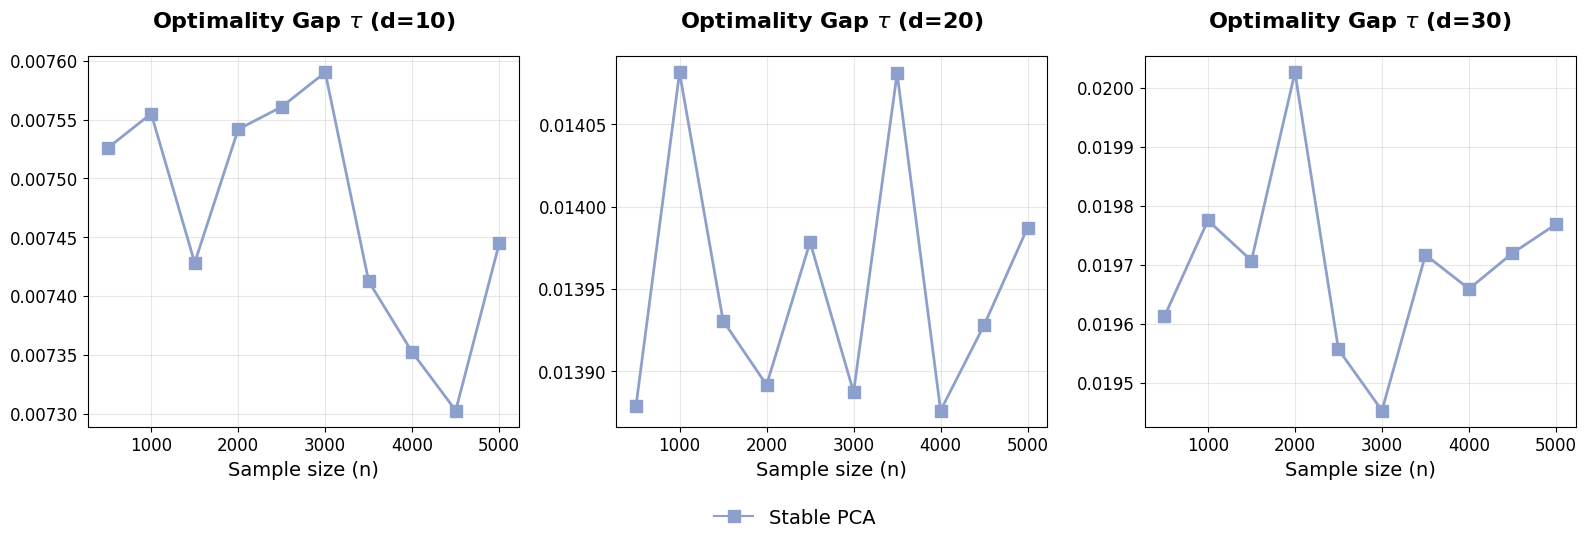

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
plt.subplots_adjust(bottom=0.25)
# Color setup
set2_colors = ListedColormap(plt.cm.Set2.colors)
color = set2_colors(2)

# Calculate means
d20_means = {
    'stable': [np.mean(errors[10][n_l])/2 for n_l in n_values]
}
d40_means = {
    'stable': [np.mean(errors[20][n_l])/2 for n_l in n_values]
}
d60_means = {
    'stable': [np.mean(errors[30][n_l])/2 for n_l in n_values]
}

ax1.plot(n_values, d20_means['stable'], '-s', color=color, 
         markersize=8, linewidth=2, label='Stable PCA')

ax1.set_xlabel('Sample size (n)', fontsize=14)
ax1.set_title(r'Optimality Gap $\tau$ (d=10)', fontsize=16, weight='bold', pad=20)
ax1.grid(True, alpha=0.3)

ax2.plot(n_values, d40_means['stable'], '-s', color=color, 
         markersize=8, linewidth=2, label='Stable PCA')

ax2.set_xlabel('Sample size (n)', fontsize=14)
ax2.set_title(r'Optimality Gap $\tau$ (d=20)', fontsize=16, weight='bold', pad=20)
ax2.grid(True, alpha=0.3)

ax3.plot(n_values, d60_means['stable'], '-s', color=color, 
         markersize=8, linewidth=2, label='Stable PCA')

ax3.set_xlabel('Sample size (n)', fontsize=14)
ax3.set_title(r'Optimality Gap $\tau$ (d=30)', fontsize=16, weight='bold', pad=20)
ax3.grid(True, alpha=0.3)


# Create proxy artists for legend
stable_proxy = mlines.Line2D([], [], color=color, marker='s', linestyle='-',
                           markersize=8, label='Stable PCA')

# Create a single legend below both subplots
fig.legend(handles=[stable_proxy],
          loc='lower center', 
          ncol=2, 
          frameon=False,
          fontsize=14,
          bbox_to_anchor=(0.5, -0.1))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig('lost_info.png', bbox_inches='tight')
plt.show()